In [25]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
import pickle
import numpy as np
from scipy.misc import imread, imsave
from pathlib import Path

import matplotlib.pyplot as plt
%matplotlib inline

from src.enhancer import ImageComparator
from src.enhancer.enhancers import ENHANCERS

In [27]:
base_path = Path('test-2')
originals_path = base_path / 'original'
masks_path = base_path / 'mask'
weight_maps_path = base_path / 'weight-map'

filenames = [file.stem for file in originals_path.iterdir()]
filenames

['flickr-ferrari',
 'flickr-bee',
 'flickr-hamster',
 'strawberry-3',
 'strawberry-2',
 'flickr-candle',
 'flickr-butterflies',
 'strawberry-1',
 'flickr-sunflower',
 'flickr-strawberry']

In [28]:
filename = 'z-values/strawberry.pkl'
zcollection = pickle.load(open(filename, 'rb'))

zcollection.descriptors['gray_hist'].quantiles

array([[  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          2.72965874e-04,   7.91836763e-04,   1.94306055e-03,
          3.38888890e-03,   1.87878788e-03,   1.26399996e-03,
          7.26726721e-04,   6.62251623e-05,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00],
       [  2.35435436e-03,   1.39017198e-02,   2.71093342e-02,
          3.89813334e-02,   4.21469808e-02,   4.19596992e-02,
          3.83000001e-02,   3.50111723e-02,   3.27627622e-02,
          2.79959831e-02,   2.37964075e-02,   2.11839993e-02,
          1.67093333e-02,   1.09173330e-02,   4.66666650e-03,
          1.73333334e-03],
       [  1.98742524e-02,   3.98932584e-02,   5.69747910e-02,
          6.71767816e-02,   6.84799999e-02,   6.49187788e-02,
          6.20626956e-02,   5.66223413e-02,   5.38191497e-02,
          4.86080013e-02,   4.63712588e-02,   4.12574857e-02,
          3.67428586e-02,   2.76800003e-02,   1.75519995e-02,
          1.1024

(-0.5, 499.5, 749.5, -0.5)

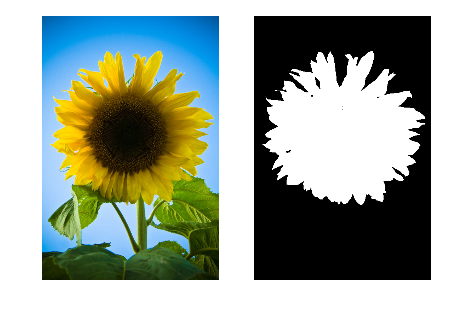

In [29]:
filename = 'z-values/sunflower.pkl'
zcollection = pickle.load(open(filename, 'rb'))

for key in zcollection.reject('lightness_layout', 'chroma_layout', 'hue_layout', 'details_hist',
                                              'frequency_hist').descriptors:
    dir_path = base_path / key
    dir_path.mkdir(exist_ok=True, parents=True)

keyword = 'flickr-sunflower'
image = imread(originals_path / ('%s.jpg' % keyword))
seg_b = imread(masks_path / ('%s-mask.png' % keyword)).astype(np.bool)

plt.rcParams['figure.figsize'] = 5, 5
plt.subplot(121)
plt.imshow(image)
plt.axis('off')

plt.subplot(122)
plt.imshow(seg_b, cmap='gray')
plt.axis('off')

In [30]:
from src.descriptors.descriptors import DESCRIPTORS
image_comparator = ImageComparator()

for key in zcollection.reject('lightness_layout', 'chroma_layout', 'hue_layout', 'details_hist',
                                              'frequency_hist').descriptors:
    delta, _ = image_comparator.compare_descriptor(image, key, zcollection.descriptors[key])
    z_delta = zcollection.descriptors[key].descriptor * delta
    
    # Global enhancement
    result_g = ENHANCERS[key].enhance(image, z_delta, 2)
    imsave(base_path / key / ('%s-g-g.jpg' % keyword), result_g)

    # Local enhancement
    result_l = ENHANCERS[key].enhance(image, z_delta, 2, mask=seg_b)
    imsave(base_path / key / ('%s-g-l.jpg' % keyword), result_l)
    
print(image_comparator.compare(image, zcollection.reject('lightness_layout', 'chroma_layout', 'hue_layout', 'details_hist',
                                              'frequency_hist'))[0])
# print(image_comparator.compare(image, zcollection.reject('lightness_layout', 'chroma_layout', 'hue_layout', 'details_hist',
#                                               'frequency_hist'), seg_b)[0])

lab_hist


chroma_hist


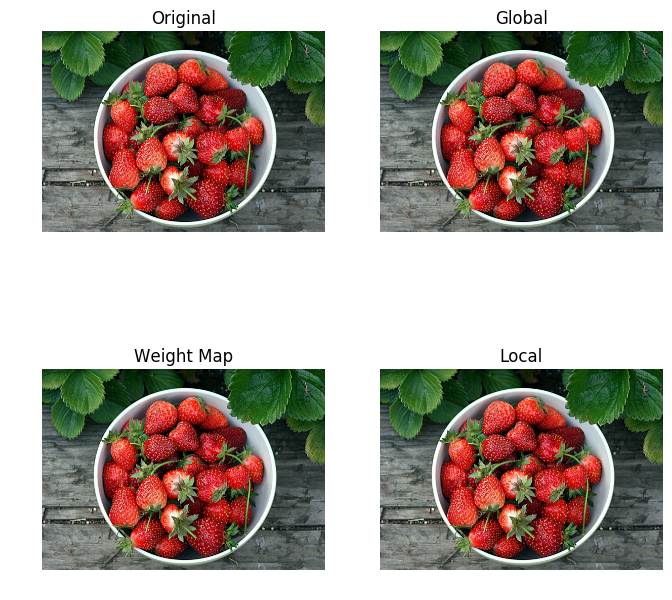

In [17]:
image_comparator = ImageComparator()
key, z_delta = image_comparator.compare(image, zcollection)
print(key)

# Global enhancement
result_g = ENHANCERS[key].enhance(image, z_delta, 2)
#imsave(g_g_path / ('%s.jpg' % keyword), result_g)

# Mask based enhancement
weight_map = ENHANCERS[key].compute_weight_map(image, zcollection.descriptors[key].descriptor)
result_w = weight_map * result_g + (1 - weight_map) * image
result_w = result_w.astype(np.uint8)
# imsave(weight_maps_path / ('%s.jpg' % keyword), weight_map)
# imsave(g_w_path / ('%s.jpg' % keyword), result_w)
       
# Local enhancement
result_l = ENHANCERS[key].enhance(image, z_delta, 2, mask=seg_b)
# imsave(g_l_path / ('%s.jpg' % keyword), result_l)

plt.rcParams['figure.figsize'] = 8, 8
plt.subplot(2, 2, 1)
plt.imshow(image)
plt.axis('off')
plt.title('Original')

plt.subplot(2, 2, 2)
plt.imshow(result_g)
plt.axis('off')
plt.title('Global')

plt.subplot(2, 2, 3)
plt.imshow(result_w)
plt.axis('off')
plt.title('Weight Map')

plt.subplot(2, 2, 4)
plt.imshow(result_l)
plt.axis('off')
plt.title('Local')

gray_hist


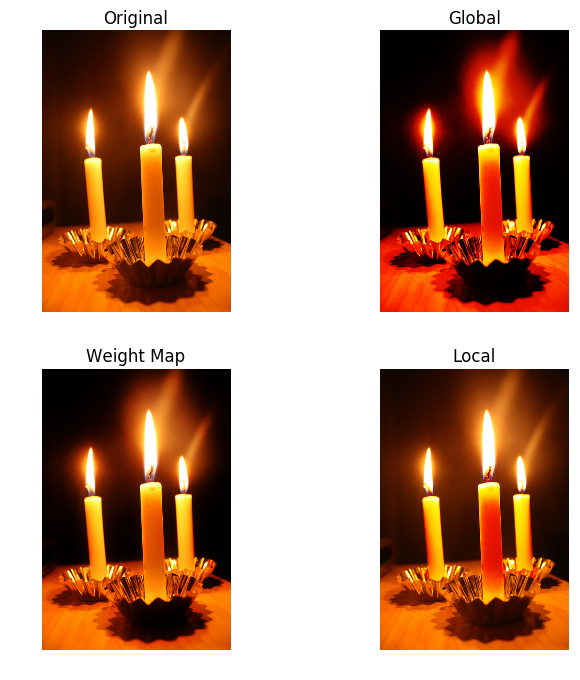

In [198]:
image_comparator = ImageComparator()
key, z_delta = image_comparator.compare(image, zcollection, mask=seg_b)
print(key)

# Global enhancement
result_g = ENHANCERS[key].enhance(image, z_delta, 2)
imsave(l_g_path / ('%s.jpg' % keyword), result_g)

# Mask based enhancement
weight_map = ENHANCERS[key].compute_weight_map(image, zcollection.descriptors[key].descriptor)
result_w = weight_map * result_g + (1 - weight_map) * image
result_w = result_w.astype(np.uint8)
imsave(l_w_path / ('%s.jpg' % keyword), result_w)
       
# Local enhancement
result_l = ENHANCERS[key].enhance(image, z_delta, 2, mask=seg_b)
imsave(l_l_path / ('%s.jpg' % keyword), result_l)

plt.rcParams['figure.figsize'] = 8, 8
plt.subplot(2, 2, 1)
plt.imshow(image)
plt.axis('off')
plt.title('Original')

plt.subplot(2, 2, 2)
plt.imshow(result_g)
plt.axis('off')
plt.title('Global')

plt.subplot(2, 2, 3)
plt.imshow(result_w)
plt.axis('off')
plt.title('Weight Map')

plt.subplot(2, 2, 4)
plt.imshow(result_l)
plt.axis('off')
plt.title('Local')

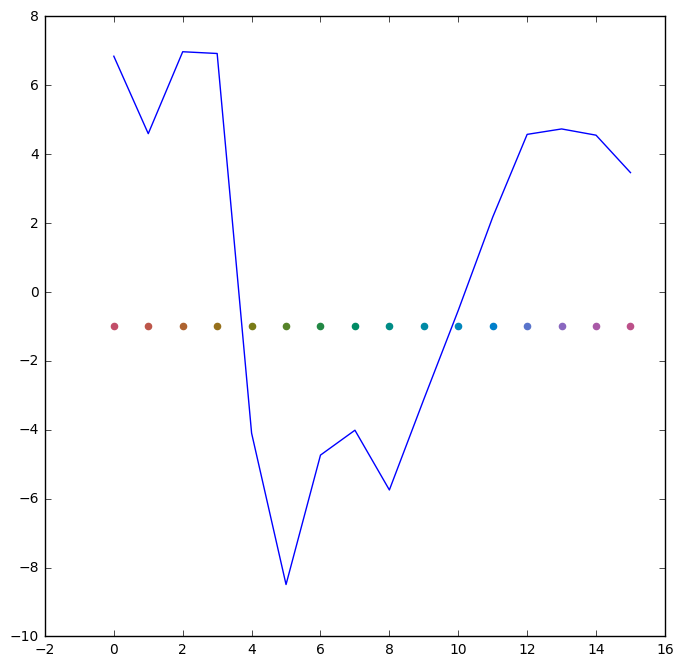

In [114]:
from src.shared import rgb_hue

plt.plot(zcollection.descriptors['hue_angle_hist'].descriptor)
for i in range(16):
    plt.scatter(i, -1, color=rgb_hue[i, :])

In [82]:
zcollection.descriptors['rgb_hist'].descriptor

array([[[ -1.29818440e+01,  -1.12949132e+01,  -5.75083323e+00,
          -2.42299844e+00,  -1.56493374e+00,  -1.13161693e+00,
          -8.45194238e-01,  -4.65342989e-01],
        [ -1.97948764e+00,  -8.87329208e+00,  -8.04223798e+00,
          -4.91176355e+00,  -3.02717530e+00,  -2.18162763e+00,
          -1.37556773e+00,  -6.33008935e-01],
        [  5.20077718e+00,   2.53967048e-01,  -3.39937764e+00,
          -4.40579956e+00,  -3.66396142e+00,  -2.80811382e+00,
          -1.91924316e+00,  -1.02447686e+00],
        [  3.19294012e+00,   1.53507837e+00,   6.21222901e-01,
          -9.63881006e-01,  -2.51238709e+00,  -2.29389364e+00,
          -2.14687068e+00,  -1.04264814e+00],
        [  1.32747473e+00,   1.15431166e+00,   6.69697021e-01,
           1.41271508e-01,  -6.97372308e-01,  -8.02321839e-01,
          -1.33808079e+00,  -1.00086200e+00],
        [  6.82350108e-01,   8.04409825e-01,   5.11395418e-01,
           4.47082067e-01,   3.38675495e-02,  -4.11078176e-01,
          -4.6

In [121]:
a = z_delta
a = np.abs(z_delta)

a[a>0].size

145

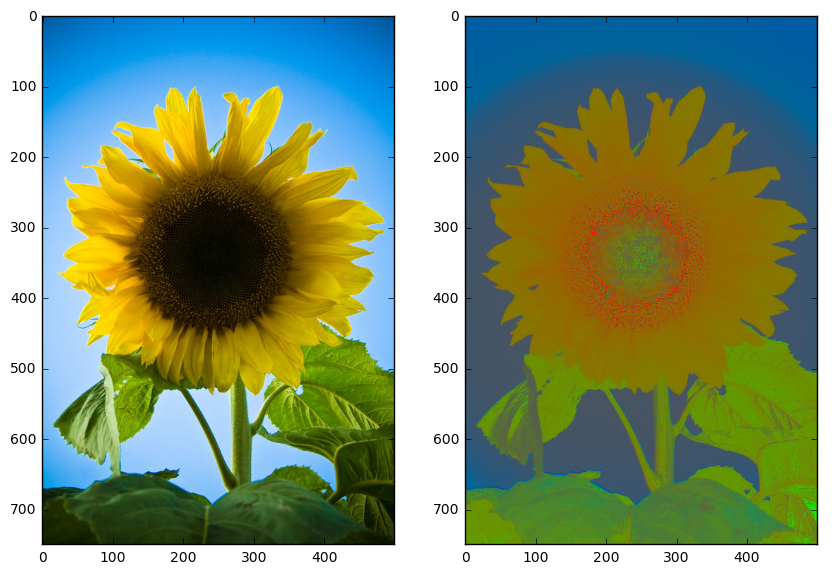

In [86]:
res = image.astype(np.float32)
rgb_sum = image.sum(axis=2)
r = res[:, :, 0] / rgb_sum
g = res[:, :, 1] / rgb_sum
b = res[:, :, 2] / rgb_sum

res = np.dstack([r, g, b])

plt.rcParams['figure.figsize'] = 10, 10

plt.subplot(121)
plt.imshow(image)

plt.subplot(122)
plt.imshow(res)

imsave('original.jpg', image)
imsave('result.jpg', res)

In [9]:
.shape

(333, 500)